# UCI Adult Dataset
https://archive.ics.uci.edu/ml/datasets/adult


In [1]:
import copy 
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn import metrics
from sklearn import  svm, tree, linear_model

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from torch import optim
import fairtorch
device = "cuda" if torch.cuda.is_available() else "cpu"



#device = "cpu"
print(device)

cpu


In [2]:
data = fetch_openml(data_id=1590, as_frame=True)

In [3]:
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1

In [4]:
classifier = tree.DecisionTreeClassifier()

classifier.fit(X, y_true)

y_pred = classifier.predict(X)

print("acc: ", metrics.accuracy_score(y_true, y_pred))

acc:  0.9998976290897179


In [5]:
classifier = linear_model.LogisticRegression()

classifier.fit(X, y_true)

y_pred = classifier.predict(X)

print("acc: ", metrics.accuracy_score(y_true, y_pred))

acc:  0.7979198231030671


In [6]:
# chance rate
print(y_true.sum()/y_true.shape[0])


0.23928176569346055


In [7]:
print(X.shape)

(48842, 105)


In [8]:
sex = data.data['sex']

In [9]:
print(sex)

0          Male
1          Male
2          Male
3          Male
4        Female
          ...  
48837    Female
48838      Male
48839    Female
48840      Male
48841    Female
Name: sex, Length: 48842, dtype: category
Categories (2, object): ['Female', 'Male']


In [10]:
# data set

class Data(Dataset):
    def __init__(self, X, y, sensitive):
        self.X = X.values.astype(np.float32)
        self.y = y.values.astype(np.float32)
        #self.y = np.ones(shape=y.shape).astype(np.float32)
        sencat = sensitive.unique()
        # print(sencat)
        self.c2i = dict(zip(list(sencat), range(len(sencat))))
        self.i2c = dict(zip(range(len(sencat)),list(sencat)))
        self.sensitive = sensitive
        self.sensitive_id = self.sensitive.map(self.c2i)

    def __len__(self):
        return len(X)
    
    def __getitem__(self, idx):
        return {"X": self.X[idx], "y": self.y[idx].reshape(-1), "A": self.sensitive_id[idx]}



In [11]:
dataset = Data(X, y_true, sex)

train_size = int(dataset.__len__() * 0.7)
test_size = dataset.__len__() - train_size 


# 分割
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


# dataloader

train_loader = DataLoader(train_dataset, batch_size=2**10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2**10, shuffle=True)


In [12]:
# model

hiden_dim = 2**9
model = nn.Sequential(
          nn.Linear(X.shape[1], hiden_dim),
          nn.Dropout(),
          nn.ReLU(),
          nn.Linear(hiden_dim, hiden_dim),
          nn.Dropout(),
          nn.ReLU(),
          nn.Linear(hiden_dim, 1),
          nn.Dropout(),
        )


for param in model.parameters():
    nn.init.normal_(param, 0, 1e-7)
model.train()

Sequential(
  (0): Linear(in_features=105, out_features=512, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): Dropout(p=0.5, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=1, bias=True)
  (7): Dropout(p=0.5, inplace=False)
)

In [13]:
criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.Adam(model.parameters())
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)



In [14]:
# 普通に学習
epoch = 25
model = model.to(device)
train_loss = []
train_acc = []


for epo in range(epoch):
    # train 
    n_samples = 0
    total_loss = 0
    ys_true = []
    ys_pred = []
    total_correct_results_sum = 0

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        n_1iter = data["y"].size(0)
        #print(data["X"].size())
        #print(data["y"].size())

        logit = model(data["X"].to(device))
        loss = criterion(logit, data["y"].to(device))
        loss.backward()
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=10, norm_type="inf")
        optimizer.step()
        """
        if i ==0 or i == len(train_loader) -1:
            print("logit", logit.size(), "\n", logit.detach().cpu().numpy().reshape(-1))
            print("logit", data["y"].size(), "\n", data["y"].detach().cpu().numpy().reshape(-1))
        """
        loss = loss.detach().cpu().float() 
        #print("loss:", loss.item(), end="   ")
        #print("epoch: {}    loss {:.5f}".format(epo, loss))
        total_loss += loss* n_1iter
        n_samples += n_1iter
        y_bin_pred = torch.round(F.sigmoid(logit.detach().cpu().view(-1)))
        ys_pred += y_bin_pred .view(-1).numpy().tolist()
        y_test = data["y"].cpu()
        ys_true += y_test.view(-1).numpy().tolist()
        correct_results_sum = (y_bin_pred == y_test).sum().float()
        total_correct_results_sum += correct_results_sum

    total_loss /= n_samples
    print("epoch: {}    loss {:.5f}".format(epo, total_loss))
    train_loss.append(float(total_loss.float()))
    train_acc.append(float(total_correct_results_sum/n_samples))


epoch: 0    loss 0.67294
epoch: 1    loss 0.62905
epoch: 2    loss 0.62237
epoch: 3    loss 0.62218
epoch: 4    loss 0.62370
epoch: 5    loss 0.62085
epoch: 6    loss 0.62095
epoch: 7    loss 0.61770
epoch: 8    loss 0.61653
epoch: 9    loss 0.62084
epoch: 10    loss 0.61216
epoch: 11    loss 0.61172
epoch: 12    loss 0.60915
epoch: 13    loss 0.60901
epoch: 14    loss 0.60822
epoch: 15    loss 0.61052
epoch: 16    loss 0.61676
epoch: 17    loss 0.61239
epoch: 18    loss 0.60932
epoch: 19    loss 0.60832
epoch: 20    loss 0.61250
epoch: 21    loss 0.61089
epoch: 22    loss 0.63054
epoch: 23    loss 0.61355
epoch: 24    loss 0.61071


In [15]:
# test 
model.eval()
with torch.no_grad():
    test_loss = 0
    total_loss =0
    total_correct_results_sum = 0
    n_samples = 0
    ys_true = []
    ys_pred = []
    test_sensitive = []
    for i, data in enumerate(test_loader):
        n_1iter = data["y"].size(0)
        test_sensitive += list(data["A"].cpu().numpy())
        optimizer.zero_grad()
        #print(data["X"].size())
        logit = model(data["X"].to(device))
        loss = criterion(logit, data["y"].to(device))
        optimizer.step()
        loss = loss.detach().cpu().float() * n_1iter
        total_loss += loss

        y_bin_pred = torch.round(F.sigmoid(logit.detach().cpu().view(-1)))
        ys_pred += y_bin_pred .view(-1).numpy().tolist()
        y_test = data["y"].cpu()
        ys_true += y_test.view(-1).numpy().tolist()
        correct_results_sum = (y_bin_pred == y_test).sum().float()
        total_correct_results_sum += correct_results_sum
        n_samples += n_1iter
ys_pred = np.asarray(ys_pred)
ys_true = np.asarray(ys_true)

total_loss /= n_samples
test_loss = total_loss
test_acc = metrics.accuracy_score(ys_true, np.round(ys_pred))


In [16]:
print("train BCE loss: {}".format(train_loss))
print("test Acc: {}".format(train_acc))
print("test BCE loss: {}".format(test_loss))
print("test Acc: {}".format(test_acc))
#print(total_correct_results_sum , n_samples)

train BCE loss: [0.6729446649551392, 0.6290457844734192, 0.6223658323287964, 0.6221790313720703, 0.6237037777900696, 0.6208457350730896, 0.620948851108551, 0.6176978349685669, 0.6165283918380737, 0.6208379864692688, 0.6121552586555481, 0.6117231249809265, 0.6091492772102356, 0.6090109348297119, 0.6082236766815186, 0.6105225682258606, 0.6167649030685425, 0.6123870611190796, 0.6093171238899231, 0.6083210110664368, 0.6125045418739319, 0.6108883023262024, 0.6305440068244934, 0.6135485172271729, 0.6107122898101807]
test Acc: [759.5313110351562, 763.158447265625, 762.6074829101562, 761.2478637695312, 764.5147705078125, 763.8331298828125, 763.0248413085938, 762.2752075195312, 760.0203857421875, 759.2567138671875, 758.3392333984375, 763.1204223632812, 762.220947265625, 762.3954467773438, 760.4662475585938, 762.1795043945312, 767.6725463867188, 765.823486328125, 762.0368041992188, 764.2604370117188, 764.91748046875, 762.7123413085938, 759.1685180664062, 764.6021118164062, 763.4096069335938]
tes

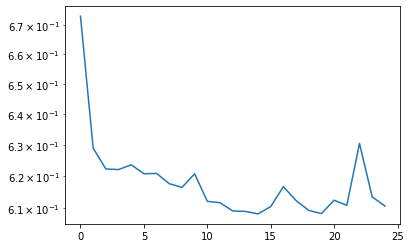

In [17]:
plt.plot(train_loss)
plt.yscale("log")

In [18]:
auc_score = metrics.roc_auc_score(ys_true, ys_pred)

print("AUC: ", auc_score)

AUC:  0.5523189393761312


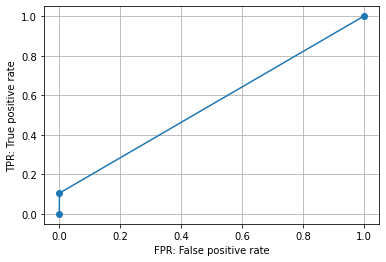

In [19]:
fpr, tpr, thresholds =  metrics.roc_curve(ys_true, ys_pred)

plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()


max acc:  0.7883709820514571


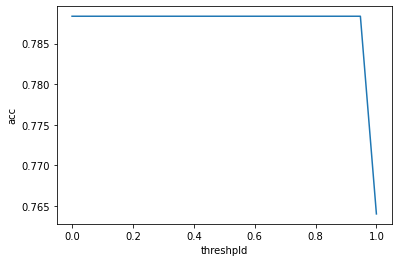

In [20]:
accs = []
thresh = np.linspace(0, 1, 20)
for t in thresh:
    test_acc = metrics.accuracy_score(ys_true, ((copy.deepcopy(np.array(ys_pred)) > t ).astype(float) ).astype(float))
    accs.append(test_acc)


plt.plot(thresh, accs)
plt.ylabel("acc")
plt.xlabel("threshpld")
print("max acc: ", np.max(accs))

とりあえずまあ、いいかぁ

In [21]:
ys_bin_pred = (ys_pred > 0.5).astype(float)

## FairLearnで公平性をチェック

In [32]:
from fairlearn import metrics as flm



In [33]:
print(len(ys_true))
print(len(ys_bin_pred))

14653
14653


## min-max最適化でDPを満たすなMLPを学習

## パラメーターを変えて公平になっているか確認

In [36]:
device= "cpu"
 # 制約付きの学習
selection_rates = []
hiden_dim = 2**9
model_fair = nn.Sequential(
            nn.Linear(X.shape[1], hiden_dim),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(hiden_dim, 1),
            nn.Dropout(),
            )
model_fair = model_fair.to(device)
for B in np.linspace(0, 1.5, 10):
    
    
    for param in model_fair.parameters():
        nn.init.normal_(param, 0, 1e-7)


    criterion = nn.BCEWithLogitsLoss()
    dp_loss = fairtorch.DemographicParityLoss(sensitive_classes=[0, 1], alpha=B).to(device)
    #optimizer = optim.SGD(model_fair.parameters(), lr=0.1)
    optimizer = optim.Adam(model_fair.parameters())

    epoch = 25
    
    train_loss = []
    train_acc = []


    model_fair.train()
    for epo in range(epoch):
        # train 
        n_samples = 0
        total_loss = 0
        ys_true = []
        ys_pred = []
        total_correct_results_sum = 0



        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            n_1iter = data["y"].size(0)
            X = data["X"].to(device)
            A = data["A"].to(device)
            logit = model_fair(X)

            
            error = criterion(logit, data["y"].to(device))
            #print(X.device, logit.device, A.device)
            L = error + dp_loss(X, logit, A)
            L.backward()

            optimizer.step()

            loss = error.detach().cpu().float() 
            #print("loss:", loss.item(), end="   ")
            #print("epoch: {}    loss {:.5f}".format(epo, loss))
            total_loss += loss* n_1iter
            n_samples += n_1iter
            y_bin_pred = torch.round(F.sigmoid(logit.detach().cpu().view(-1)))
            ys_pred += y_bin_pred .view(-1).numpy().tolist()
            y_test = data["y"].cpu()
            ys_true += y_test.view(-1).numpy().tolist()
            correct_results_sum = (y_bin_pred == y_test).sum().float()
            total_correct_results_sum += correct_results_sum

        #scheduler.step()
        total_loss /= n_samples
        print("epoch: {}    loss {:.5f}".format(epo, total_loss))
        train_loss.append(float(total_loss.float()))
        train_acc.append(float(total_correct_results_sum/n_samples))
    # test 
    model_fair.eval()
    with torch.no_grad():
        test_loss = 0
        total_loss =0
        total_correct_results_sum = 0
        n_samples = 0
        ys_true = []
        ys_pred = []
        test_sensitive = []
        for i, data in enumerate(test_loader):
            n_1iter = data["y"].size(0)
            test_sensitive += list(data["A"].cpu().numpy())
            optimizer.zero_grad()
            #print(data["X"].size())
            logit = model_fair(data["X"].to(device))
            loss = criterion(logit, data["y"].to(device))
            optimizer.step()
            loss = loss.detach().cpu().float() * n_1iter
            total_loss += loss

            y_bin_pred = torch.round(F.sigmoid(logit.detach().cpu().view(-1)))
            ys_pred += y_bin_pred .view(-1).numpy().tolist()
            y_test = data["y"].cpu()
            ys_true += y_test.view(-1).numpy().tolist()
            correct_results_sum = (y_bin_pred == y_test).sum().float()
            total_correct_results_sum += correct_results_sum
            n_samples += n_1iter
    ys_pred = np.asarray(ys_pred)
    ys_true = np.asarray(ys_true)

    total_loss /= n_samples
    test_loss = total_loss
    test_acc = metrics.accuracy_score(ys_true, np.round(ys_pred))
    ys_bin_pred = (ys_pred > 0.5).astype(float)
    sr = flm.selection_rate_group_summary(ys_true, ys_bin_pred, sensitive_features=test_sensitive)
    #print(sr)
    sr["B"] = B
    sr["test_acc"] = test_acc

    selection_rates.append( sr )



epoch: 0    loss 1.61631
epoch: 1    loss 0.65771
epoch: 2    loss 0.65270
epoch: 3    loss 0.64848
epoch: 4    loss 0.64242
epoch: 5    loss 0.64300
epoch: 6    loss 0.63786
epoch: 7    loss 0.63729
epoch: 8    loss 0.63707
epoch: 9    loss 0.63335
epoch: 10    loss 0.63254
epoch: 11    loss 0.62721
epoch: 12    loss 0.62729
epoch: 13    loss 0.62853
epoch: 14    loss 0.62862
epoch: 15    loss 0.62530
epoch: 16    loss 0.62625
epoch: 17    loss 0.62602
epoch: 18    loss 0.62225
epoch: 19    loss 0.62368
epoch: 20    loss 0.62148
epoch: 21    loss 0.62394
epoch: 22    loss 0.62260
epoch: 23    loss 0.62400
epoch: 24    loss 0.62359


NameError: name 'selection_rate_group_summary' is not defined

In [ ]:
print( selection_rates )

In [ ]:
Bs = list(map( lambda x : x["B"],  selection_rates))
Accs = list(map( lambda x : x["test_acc"],  selection_rates))
As_0 = list(map( lambda x : x['by_group'][0],  selection_rates))
As_1 = list(map( lambda x : x['by_group'][1],  selection_rates))
fig, ax1 = plt.subplots()
ax1.plot(Bs, As_0, label="A:0")
ax1.plot(Bs, As_1, label="A:1")
ax2 = ax1.twinx()
ax2.plot(Bs, Accs, c="green")
ax2.set_ylabel("acc")

ax1.set_ylabel("selection rate")
ax1.set_xlabel("B")

plt.legend()
plt.show()


# カテゴリごとのselection rate

In [ ]:
Bs = list(map( lambda x : x["B"],  selection_rates))
As_gap = list(map( lambda x : np.abs(x['by_group'][0] - x['by_group'][1]) ,  selection_rates))


plt.plot(Bs, As_gap, label="gap")

plt.ylabel("selection rate")
plt.xlabel("B")

plt.legend()
plt.show()
# 縦軸がsensitive columnの0と1のグループごとのselection rateのgap

全然、selection rateを減少させられていない。
他の方法を考えよう！